<center>
<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg">

## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course
    
Authors: [Ilya Baryshnikov](https://www.linkedin.com/in/baryshnikov-ilya/), [Maxim Uvarov](https://www.linkedin.com/in/maxis42/), and [Yury Kashnitsky](https://yorko.github.io). Translated and edited by [Inga Kaydanova](https://www.linkedin.com/in/inga-kaidanova-a92398b1/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #2 (demo)
## <center>Analyzing cardiovascular disease data 

In this assignment, you will answer questions about a dataset on cardiovascular disease. You do not need to download the data: it is already in the repository. There are some Tasks that will require you to write code. Complete them and then answer the questions in the [form](https://docs.google.com/forms/d/13cE_tSIb6hsScQvvWUJeu1MEHE5L6vnxQUbDYpXsf24). 

#### Problem

Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

#### Data description

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

Let's get to know our data by performing a preliminary data analysis.

#  Part 1. Preliminary data analysis

First, we will initialize the environment:

In [1]:
# Import all required modules
import pandas as pd
import numpy as np

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import plotting modules
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

You will use the `seaborn` library for visual analysis, so let's set that up too:

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

To make it simple, we will work only with the training part of the dataset:

In [6]:
#чтение с гугл диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_csv("/content/drive/MyDrive/ML/mlbootcamp5_train.csv")
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


It would be instructive to peek into the values of our variables.
 
Let's convert the data into *long* format and depict the value counts of the categorical features using [`factorplot()`](https://seaborn.pydata.org/generated/seaborn.factorplot.html).

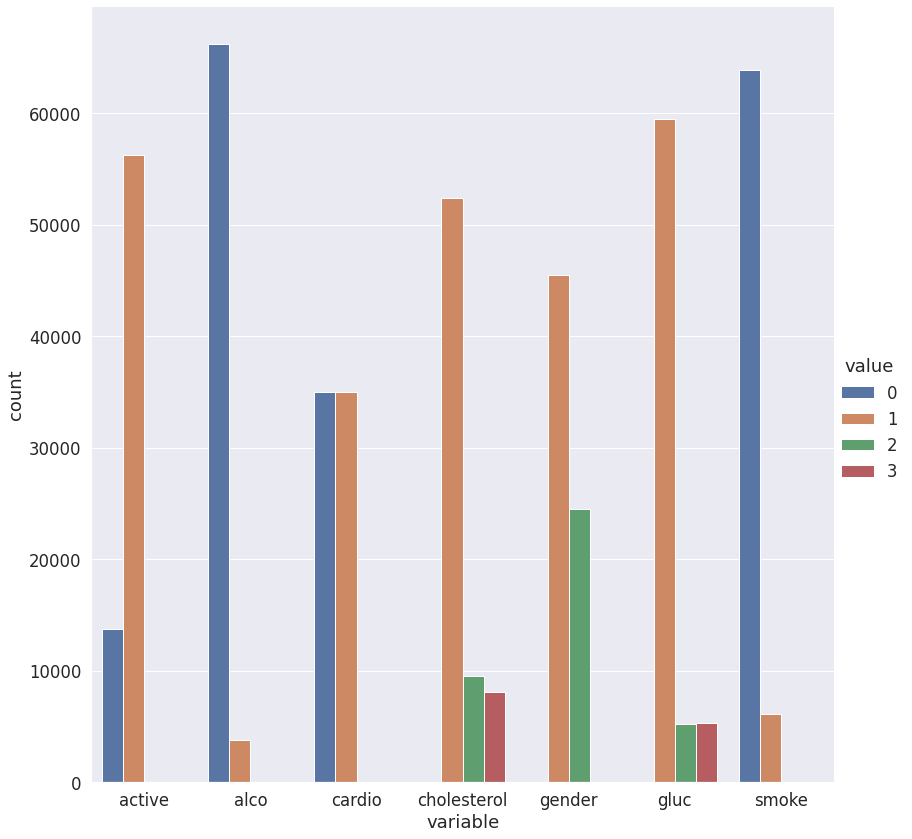

In [8]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active', 'cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               data=df_uniques, kind='bar', size=12);

We can see that the target classes are balanced. That's great!

Let's split the dataset by target values. Can you already spot the most significant feature by just looking at the plot?

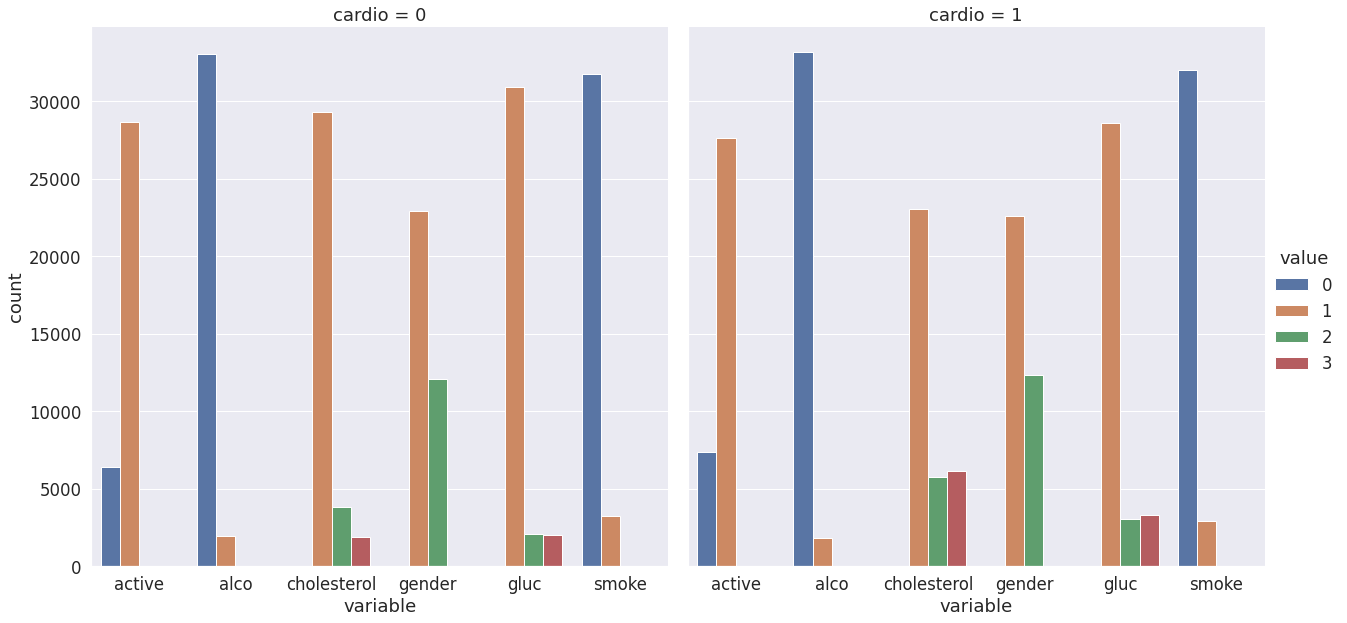

In [9]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active'], 
                     id_vars=['cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value', 
                                              'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               col='cardio', data=df_uniques, kind='bar', size=9);

You can see that the distribution of cholesterol and glucose levels great differs by the value of the target variable. Is this a coincidence?

Now, let's calculate some statistics for the feature unique values:

In [10]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


In the end, we have:
- 5 numerical features (excluding *id*);
- 7 categorical features;
- 70000 records in total.

## 1.1. Basic observations

**Question 1.1. (1 point). How many men and women are present in this dataset? Values of the `gender` feature were not given (whether "1" stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average. **
1. 45530 women and 24470 men
2. 45530 men and 24470 women
3. 45470 women and 24530 men
4. 45470 men and 24530 women

In [11]:
df1 = (df[df['gender'] == 2])
df1["height"].mean()

169.94789538210054

In [12]:
len(df1)

24470

In [13]:
df1 = (df[df['gender'] == 1])
df1["height"].mean()

161.35561168460356

In [14]:
len(df1)

45530

Ответ: 3

**Question 1.2. (1 point). Which gender more often reports consuming alcohol - men or women?**
1. women
2. men

In [15]:
df2 = (df[df['gender'] == 1])
df2 = (df2[df2['alco'] == 1])

len(df2)

1161

In [16]:
df2 = (df[df['gender'] == 2])
df2 = (df2[df2['alco'] == 1])

len(df2)

2603

In [ ]:
Ответ: 2

**Question 1.3. (1 point). What is the difference between the percentages of smokers among men and women (rounded)?**
1. 4
2. 16
3. 20
4. 24

In [31]:
Woman = (df[df['gender'] == 1])

Woman['smoke'].sum() / len(Woman) * 100

1.7856358444981333

In [32]:
Men = (df[df['gender'] == 2])

Men['smoke'].sum() / len(Men) * 100

21.88802615447487

In [22]:
21.88802615447487 - 1.7856358444981333

20.102390309976734

Ответ: 3

**Question 1.4. (1 point). What is the difference between median values of age for smokers and non-smokers (in months, rounded)? You'll need to figure out the units of feature `age` in this dataset.**

1. 5
2. 10
3. 15
4. 20

In [26]:
Smoke = (df[df['smoke'] == 1])
Smoke['age'].median() / 29.3

652.7303754266211

In [27]:
Smoke1 = (df[df['smoke'] == 0])
Smoke1['age'].median() / 29.3

673.1058020477816

In [28]:
673.1058020477816 - 652.7303754266211

20.3754266211605

Ответ: 4

## 1.2. Risk maps
### Task:

On the website for the European Society of Cardiology, a [SCORE scale](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) is provided. It is used for calculating the risk of death from a cardiovascular decease in the next 10 years. Here it is:
<img src=https://habrastorage.org/webt/ik/gx/hr/ikgxhr3w1vzqihgitgrbdorfb14.png width=30%>

Let's take a look at the upper-right rectangle, which shows a subset of smoking men aged from 60 to 65. (It's not obvious, but the values in the figure represent the upper bound).

We see the value 9 in the lower-left corner of the rectangle and 47 in the upper-right. This means that, for people in this gender-age group whose systolic pressure is less than 120, the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180).

Let's calculate that same ratio using our data.

Clarifications:
- Calculate ``age_years`` feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.
- Cholesterol level categories differ between the figure and our dataset. The conversion for the ``cholesterol`` feature is as follows: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.

In [33]:
df['years'] = round(df['age'] / 365)

df5 = (df[(df['years'] > 60) & (df['years'] <= 65) & (df['gender'] == 2) & (df['smoke'] == 1)])
df5

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years
38,52,23388,2,162,72.0,130,80,1,1,1,0,1,1,64.0
67,90,22099,2,171,97.0,150,100,3,1,1,0,1,1,61.0
182,248,22671,2,174,74.0,130,80,3,1,1,0,1,1,62.0
230,318,23376,2,175,75.0,180,100,3,1,1,1,1,1,64.0
297,410,22415,2,173,70.0,130,70,2,1,1,1,1,0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69697,99551,23224,2,151,45.0,120,70,3,1,1,1,0,1,64.0
69699,99553,23183,2,178,113.0,130,90,2,2,1,0,1,1,64.0
69814,99711,22759,2,167,76.0,120,80,1,1,1,0,1,0,62.0
69857,99775,22637,2,177,63.0,150,70,1,1,1,0,1,1,62.0


**Question 1.5. (2 points). Calculate the fraction of the people with CVD for the two segments described above. What is the ratio of these two fractions?**

1. 1
2. 2
3. 3
4. 4

In [38]:
df5[(df5['cholesterol'] == 1) & (df5['ap_hi'] < 120)]['cardio'].mean()

0.2564102564102564

In [35]:
df5[(df5['cholesterol'] == 3) & (df5['ap_hi'] >= 160) & (df5['ap_hi'] < 180)]['cardio'].mean()

0.9090909090909091

In [37]:
0.9333333333333333 / 0.2564102564102564

3.6400000000000006

Ответ: 3

## 1.3. Analyzing BMI
### Task:

Create a new feature – BMI ([Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)). To do this, divide weight in kilogramms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25. 

In [39]:
df['BMI'] = df['weight'] / (df['height'] / 100  * df['height'] / 100)

df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.0,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.0,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52.0,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.0,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48.0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,53.0,26.927438
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,62.0,50.472681
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,52.0,31.353579
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,61.0,27.099251


**Question 1.6. (2 points). Choose the correct statements:**

1. Median BMI in the sample is within the range of normal BMI values.
2. The BMI for women is on average higher than for men.
3. Healthy people have, on average, a higher BMI than the people with CVD.
4. For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women

In [40]:
df6 = df[(df['BMI'] > 18.5) & (df['BMI'] < 25)]

len(df) - len(df6)

44333

1 неверно

In [41]:
df6Woman = df[(df['gender'] == 1)]['BMI'].mean()
df6Woman

27.98758344183312

In [42]:
df6Men = df[(df['gender'] == 2)]['BMI'].mean()
df6Men

26.75444235728947

In [43]:
df6Woman - df6Men

1.2331410845436501

2 верно

In [44]:
df7CVD = df[(df['cholesterol'] == 3)]['BMI'].mean()
df7CVD

29.582314601657618

In [45]:
df7Health = df[(df['cholesterol'] == 1)]['BMI'].mean()
df7Health

27.058528826113335

3 неверно

In [46]:
df7HealthMen = df[(df['cholesterol'] == 1) & (df['gender'] == 2) & (df['alco'] == 0)]['BMI'].mean()
df7HealthMen

26.386718309339837

In [47]:
df7HealthWoman = df[(df['cholesterol'] == 1) & (df['gender'] == 1) & (df['alco'] == 0)]['BMI'].mean()
df7HealthWoman

27.395349409147034

4 верно


Ответ: 2, 4

## 1.4. Cleaning data

### Task:
We can see that the data is not perfect. It contains "dirt" and inaccuracies. We'll see this better as we visualize the data.

Filter out the following patient segments (we consider these as erroneous data)

- diastolic pressure is higher than systolic 
- height is strictly less than 2.5 percentile (Use `pd.Series.quantile` to compute this value. If you are not familiar with the function, please read the docs.)
- height is strictly more than 97.5 percentile
- weight is strictly less than 2.5 percentile
- weight is strictly more than 97.5 percentile

This is not everything that we can do to clean this data, but this is sufficient for now.

**Question 1.7. (2 points). What percent of the original data (rounded) did we throw away?**

1. 8
2. 9
3. 10
4. 11

In [48]:
prencHeight1 = pd.Series.quantile(df['height'], q = 0.025)
prencHeight1

prencHeight2 = pd.Series.quantile(df['height'], q = 0.975)
prencHeight2

prencWeight1 = pd.Series.quantile(df['weight'], q = 0.025)
prencWeight1

prencWeight2 = pd.Series.quantile(df['weight'], q = 0.975)
prencWeight2

df14 = df[(df['height'] > prencHeight1) 
         & (df['height'] < prencHeight2)  
         & (df['weight'] > prencWeight1) 
         & (df['weight'] < prencWeight2)
         & (df['ap_hi'] > df['ap_lo'])]
df14

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.0,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.0,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52.0,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.0,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48.0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,99991,19699,1,172,70.0,130,90,1,1,0,0,1,1,54.0,23.661439
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,58.0,29.384757
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,53.0,26.927438
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,61.0,27.099251


In [49]:
df15 = df[(df['ap_hi'] > df['ap_lo'])]
df15

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.0,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.0,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52.0,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.0,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48.0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,53.0,26.927438
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,62.0,50.472681
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,52.0,31.353579
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,61.0,27.099251


In [50]:
(68764 - 61203) / 68764 * 100

10.995579082077832

Ответ: 4

# Part 2. Visual data analysis

## 2.1. Correlation matrix visualization

To understand the features better, you can create a matrix of the correlation coefficients between the features. Use the initial dataset (non-filtered).

### Task:

Plot a correlation matrix using [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). You can create the matrix using the standard `pandas` tools with the default parameters.

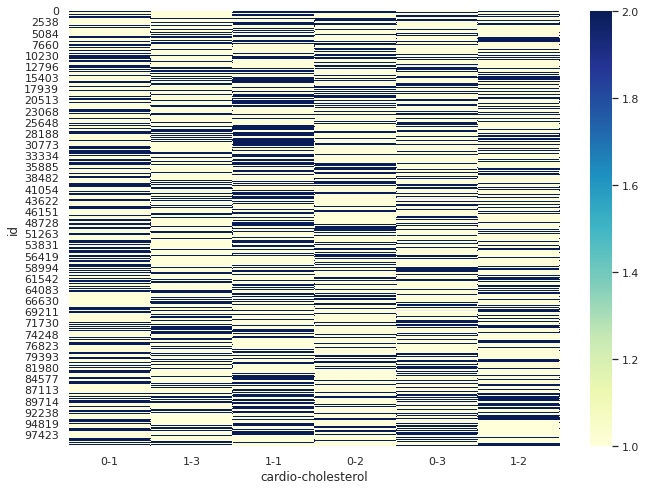

In [51]:
import seaborn as sns; sns.set_theme()

flights = df.pivot(index = "id", columns = ["cardio", "cholesterol"], values = "gender")
ax = sns.heatmap(flights, cmap = "YlGnBu")

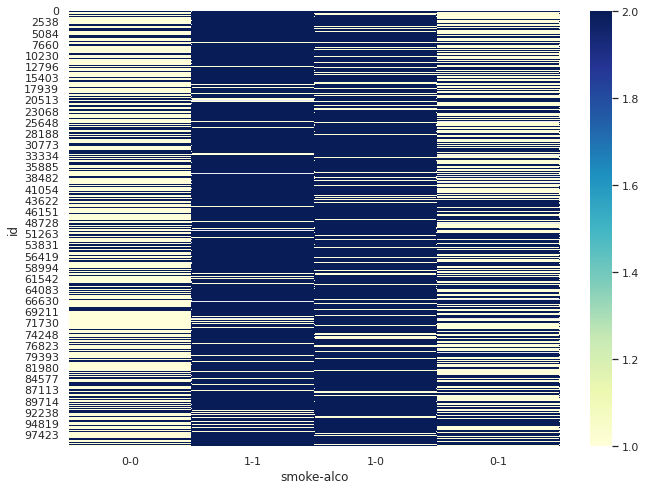

In [52]:
flights = df.pivot(index = "id", columns = ["smoke", "alco"], values = "gender")
ax = sns.heatmap(flights, cmap = "YlGnBu")

** Question 2.1. (1 point).** Which pair of features has the strongest Pearson's correlation with the *gender* feature?

1. Cardio, Cholesterol
2. Height, Smoke
3. Smoke, Alco
4. Height, Weight

## 2.2. Height distribution of men and women

From our exploration of the unique values earlier, we know that the gender is encoded by the values *1* and *2*. Although you do not know the mapping of these values to gender, you can figure that out graphically by looking at the mean values of height and weight for each value of the *gender* feature.

### Task:

Create a violin plot for the height and gender using [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Use the parameters:
- `hue` to split by gender;
- `scale` to evaluate the number of records for each gender.

In order for the plot to render correctly, you need to convert your `DataFrame` to *long* format using the `melt()` function from `pandas`. Here is [an example](https://stackoverflow.com/a/41575149/3338479) of this for your reference.

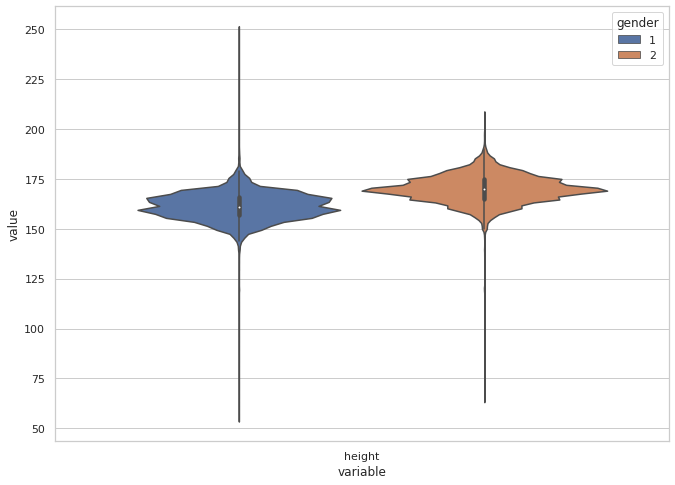

In [53]:
sns.set_theme(style = "whitegrid")
tips = pd.melt(df, value_vars = ['height'], id_vars = 'gender')
ax = sns.violinplot(x = 'variable', y = 'value', hue = 'gender', data = tips)

**Question 2.2. (1 point).** Which pair of features has the strongest Spearman correlation?

1. Height, Weight
2. Age, Weight
3. Cholesterol, Gluc
4. Cardio, Cholesterol
5. Ap_hi, Ap_lo
6. Smoke, Alco

In [54]:
df.corr(method = "spearman")

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years,BMI
id,1.000000,0.002682,0.003506,-0.001886,-0.001292,0.003258,-0.000238,0.005706,0.002789,-0.003697,0.001214,0.003766,0.003800,0.002399,-0.000472
age,0.002682,1.000000,-0.020176,-0.082292,0.061559,0.219087,0.156700,0.140113,0.091791,-0.047471,-0.030078,-0.010422,0.234429,0.998048,0.107610
gender,0.003506,-0.020176,1.000000,0.533805,0.172480,0.063174,0.066374,-0.035730,-0.018866,0.338135,0.170966,0.005866,0.008109,-0.020697,-0.087532
height,-0.001886,-0.082292,0.533805,1.000000,0.313569,0.019381,0.030534,-0.058940,-0.024369,0.197632,0.096670,-0.007367,-0.012383,-0.083634,-0.182392
weight,-0.001292,0.061559,0.172480,0.313569,1.000000,0.277749,0.254420,0.137908,0.109901,0.071676,0.068088,-0.014894,0.182701,0.062979,0.848270
ap_hi,0.003258,0.219087,0.063174,0.019381,0.277749,1.000000,0.735436,0.208722,0.105334,0.028929,0.033243,-0.001268,0.451885,0.220780,0.281102
ap_lo,-0.000238,0.156700,0.066374,0.030534,0.254420,0.735436,1.000000,0.167401,0.082474,0.026172,0.038862,0.003401,0.362572,0.157957,0.250608
cholesterol,0.005706,0.140113,-0.035730,-0.058940,0.137908,0.208722,0.167401,1.000000,0.407803,0.015220,0.041285,0.007573,0.215117,0.141935,0.174008
gluc,0.002789,0.091791,-0.018866,-0.024369,0.109901,0.105334,0.082474,0.407803,1.000000,0.000468,0.018584,-0.008610,0.091488,0.091777,0.127857
smoke,-0.003697,-0.047471,0.338135,0.197632,0.071676,0.028929,0.026172,0.015220,0.000468,1.000000,0.340094,0.025858,-0.015486,-0.047535,-0.024265


1 : 0.313569
2: -0.082292
3: 0.407803
4: 0.215117
5: 0.735436
6: 0.340094

Ответ: 5

## 2.3. Rank correlation

In most cases, *the Pearson coefficient of linear correlation* is more than enough to discover patterns in data. 
But let's go a little further and calculate a [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation). It will help us to identify such feature pairs in which the lower rank in the variational series of one feature always precedes the higher rank in the another one (and we have the opposite in the case of negative correlation).

### Task:

Calculate and plot a correlation matrix using the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).


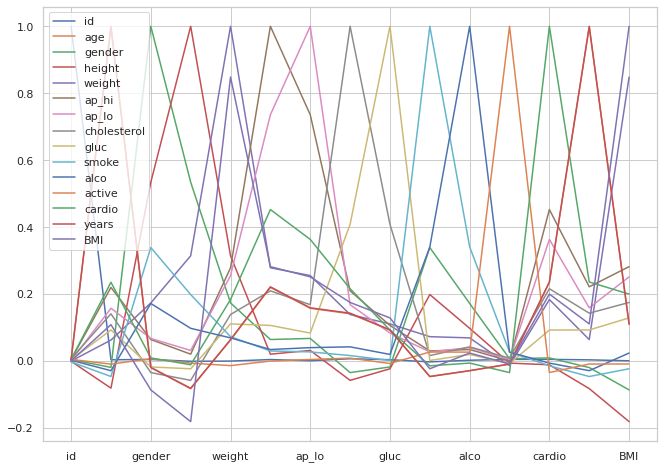

In [55]:
dfPlot = df.corr(method = "spearman")
dfPlot.plot()

**Question 2.3. (1 point).** Why do these features have strong rank correlation?

1. Inaccuracies in the data (data acquisition errors).
2. Relation is wrong, these features should not be related.
3. Nature of the data.

Ответ: 3


## 2.4. Age

Previously, we calculated the age of the respondents in years at the moment of examination.

### Task:

Create a *count plot* using [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html) with the age on the *X* axis and the number of people on the *Y* axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each *cardio* class of that age.

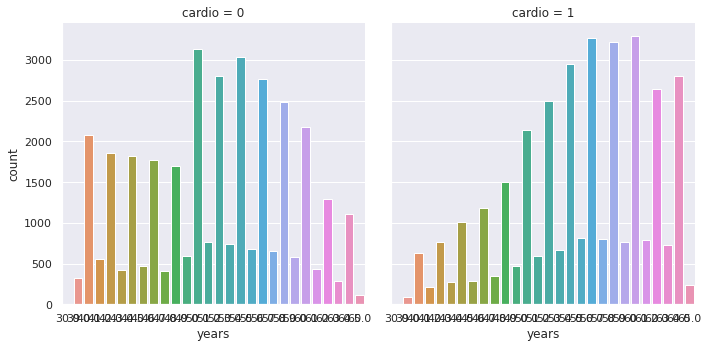

In [56]:
sns.set_theme(style = "darkgrid")
titanic = df
ax = sns.catplot(x = "years", col = "cardio", data = titanic, kind="count")

**Question 2.4. (1 point).** What is the smallest age at which the number of people with CVD outnumber the number of people without CVD?

1. 44
2. 55
3. 64
4. 70

Ответ: 2